### Read the camera parameters

```
Load Cameras (✓)
↓
Detect People + Keypoints (✓)
↓
Back-project 2D keypoints to 3D rays (✓)
↓
Compute geometric affinities (epipolar, homography) (✓)
↓
Combine with Re-ID features (if applicable) (✓)
↓
Run cross-camera matching (...)
↓
Build global identity tracks
```

In [3]:
import numpy as np
import cv2 as cv
import os 
import json
import scipy

In [14]:
class Camera():
    def __init__(self, calib_path, cam_id):
        with open(calib_path, 'r') as file:
            data = json.load(file)
            
        cam_data = None
        for cam in data["sensors"]:
            if cam['id'] == cam_id:
                cam_data = cam
                break
            
        if cam_data is None:
            raise ValueError(f"Cam ID {cam_id} not found in the calibration file")
        
        # Load camera matrix and homography 
        self.project_mat = np.array(cam_data["cameraMatrix"])
        self.homo_mat = np.array(cam_data["homography"])
        self.homo_inv = np.linalg.inv(self.homo_mat)
        self.project_mat_inv = scipy.linalg.pinv(self.project_mat)
        
        # Compute camera position from projection matrix
        self.pos = np.linalg.inv(self.project_mat[:, :-1]) @ (-self.project_mat[:, -1])
        
        # Homography for feet (offset z = 0.15)
        self.homo_feet = self.homo_mat.copy()
        self.homo_feet[:, -1] += self.project_mat[:, 2] * 0.15
        self.homo_feet_inv = np.linalg.inv(self.homo_feet)
        
        self.idx = cam_id
        self.ifx_int = int(''.join(filter(str.isdigit, cam_id)))

#### Solve the equation for finding the position of the camera:
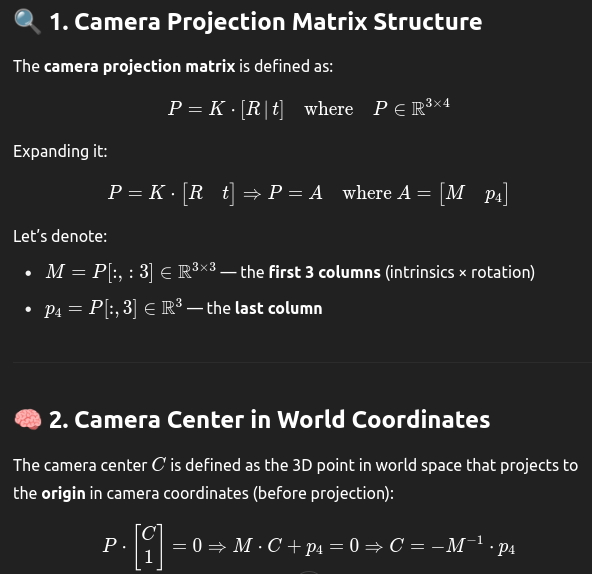

In [30]:
calib_warehouse000 = "/media/phonghuynh/New Volume/AIC2025/aicitytrack1/train/Warehouse_000/calibration.json"
cam = Camera(calib_warehouse000, "Camera_01")

print("Projection matrix:\n", cam.project_mat)
print("Camera position in 3D:", cam.pos)
print("Camera matrix: ", cam.project_mat[:, 2])
print("Camera matrix shift more z = 0.15: ", cam.project_mat[:, 2] * 0.15)
print(cam.homo_feet[:, -1])

Projection matrix:
 [[ 7.26683689e+01  4.08866286e+00 -4.50835009e+00  1.91340240e+03]
 [ 2.55555770e+00  6.59813441e+00 -6.80892197e+01  5.38073550e+02]
 [ 1.13085706e-02  2.91973355e-02 -4.69619823e-03  1.00000000e+00]]
Camera position in 3D: [-24.6949892  -23.93605275   4.65610839]
Camera matrix:  [-4.50835009e+00 -6.80892197e+01 -4.69619823e-03]
Camera matrix shift more z = 0.15:  [-6.76252514e-01 -1.02133829e+01 -7.04429734e-04]
[1.91272615e+03 5.27860167e+02 9.99295570e-01]


In [31]:
def Point2LineDist(p_3d, pos, ray):
    return np.linalg.norm(np.cross(p_3d - pos, ray), axis=-1)

In [ ]:
def Line2LineDist(pA, rayA, pB, rayB):
    if np.abs(np.dot(rayA, rayB)) > (1 - (1e-5)) * np.linalg.norm(rayA, axis=-1) * np.linalg.norm(rayB, axis=-1):
        return Point2LineDist(pA, pB, rayA)
    else:
        rayCP = np.cross(rayA, rayB)
        return np.abs((pA - pB).dot(rayCP / np.linalg.norm(rayCP, axis=-1), axis=-1))

def Line2LineDist_norm(pA, rayA, pB, rayB):
    rayCP = np.cross(rayA, rayB, axis=-1)
    rayCP_norm = np.linalg.norm(rayCP, axis=-1) + 1e-6
    return np.abs(np.sum((pA-pB) * (rayCP / rayCP_norm[:, None]), -1))

In [ ]:
def epipolar_3d_score(pA, rayA, pB, rayB, alpha_epi):
    dist = Line2LineDist(pA, rayA, pB, rayB)
    return 1 - dist / alpha_epi

def epipolar_3d_score_norm(pA, rayA, pB, rayB, alpha_epi):
    dist_norm = Line2LineDist_norm(pA, rayA, pB, rayB)
    return 1- dist_norm / alpha_epi